<a href="https://colab.research.google.com/github/itsmaul/bangkit-capstone/blob/main/All_Integrated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler

In [13]:
def preprocess_data(data):
  # Membaca file dataset
  data = pd.DataFrame(pd.read_json(data))

  # Menghitung total_income dan total_expense
  data['total_income'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Income' else 0, axis=1)
  data['total_expense'] = data.apply(lambda x: x['amount'] if x['transaction_type'] == 'Expense' else 0, axis=1)

  # Menghitung net_cashflow
  data['net_cashflow'] = data['total_income'] - data['total_expense']

  # Mengelompokkan berdasarkan bulan
  data['month'] = pd.to_datetime(data['date']).dt.to_period('M')

  # Menghitung total per bulan
  summary = data.groupby('month').agg(
    total_income = ('total_income', 'sum'),
    total_expense = ('total_expense', 'sum'),
    net_cashflow = ('net_cashflow', 'sum')
  ).reset_index()

  return summary

In [14]:
preprocess_data('merger_dataset.json')

,month,total_income,total_expense,net_cashflow
0,2023-08,1390000,1412950,-22950
1,2023-09,1607000,1443530,163470
2,2023-10,1510000,1652785,-142785
3,2023-11,1200000,1077068,122932
4,2023-12,1750000,1829508,-79508
5,2024-01,9735000,11400361,-1665361
6,2024-02,19201015,18971500,229515
7,2024-03,3620000,2670818,949182
8,2024-04,6250101,4098822,2151279
9,2024-05,4527000,6434944,-1907944


In [15]:
#Min-Max Scaler Initialization
scaler = MinMaxScaler(feature_range=(0, 1))

In [16]:
def time_series(data):
  # Rescaling dengan MinMaxScaler
  total_income = scaler.fit_transform(data[['total_income']])
  total_expense = scaler.fit_transform(data[['total_expense']])
  net_cashflow = scaler.fit_transform(data[['net_cashflow']])

  # Mengubah nilai dalam ribuan
  data['total_income'] = data['total_income'] / 1e4
  data['total_expense'] = data['total_expense'] / 1e4
  data['net_cashflow'] = data['net_cashflow'] / 1e4

  # Assign value variabel time dan series
  time = pd.to_datetime(data['month'].astype(str)).tolist()
  income = data['total_income'].tolist()
  expense = data['total_expense'].tolist()
  net_cashflow = data['net_cashflow'].tolist()

  return time, income, expense, net_cashflow

In [17]:
DATA = 'merger_dataset.json'
TIME, INCOME, EXPENSE, NET_CASHFLOW = time_series(preprocess_data(DATA))

INCOME_SCALED = scaler.inverse_transform(np.array(INCOME).reshape(-1,1)).flatten()
EXPENSE_SCALED = scaler.inverse_transform(np.array(EXPENSE).reshape(-1,1)).flatten()
NET_CASHFLOW_SCALED = scaler.inverse_transform(np.array(NET_CASHFLOW).reshape(-1,1)).flatten()

In [18]:
#Visualisasi Data

def plot_value(time, value, label):
  plt.plot(time, value, label = label)
  plt.xlabel("Bulan Transaksi")
  plt.ylabel("Jumlah Uang")
  plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
  plt.gcf().autofmt_xdate()
  plt.show()

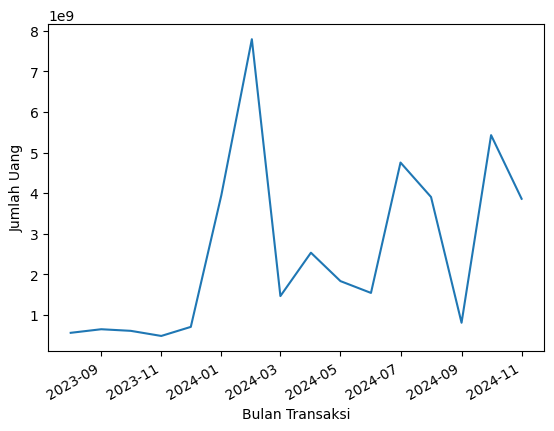

In [19]:
plot_value(TIME, INCOME_SCALED, "Pemasukan")

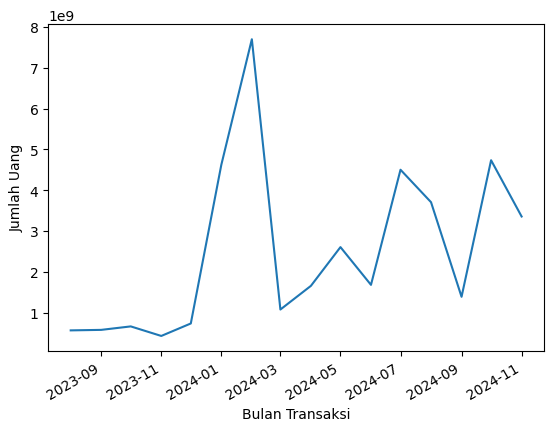

In [20]:
plot_value(TIME, EXPENSE_SCALED, "Pengeluaran")

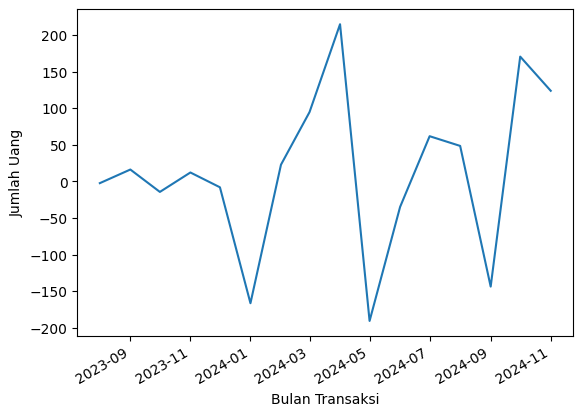

In [21]:
plot_value(TIME, NET_CASHFLOW, "Net Cashflow")

In [22]:
# Format data JSON
data_for_export = {
  "cashflow_analysis": [
    {
      "time": TIME[i].strftime('%Y-%m'),
      "total_income": INCOME[i],
      "total_expense": EXPENSE[i],
      "net_cashflow": NET_CASHFLOW[i]
    }
    for i in range(len(TIME))
  ]
}

# Simpan ke JSON
with open('clean_data.json', 'w') as json_file:
    json.dump(data_for_export, json_file)